____

# <font color=#FFAA11> Two-Temperature Model </font>

The TTM considered here is given by
$$\begin{align}
c_e \frac{\partial T_e}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_e \frac{\partial T_e}{\partial r}\right) - G (T_e - T_i), \\
c_i\frac{\partial T_i}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_i \frac{\partial T_i}{\partial r}\right) + G (T_e - T_i),
\end{align}
$$

which assumes a cylindrical plasma composed of electrons and ions with no mass flow. 

Main areas where major improvements are needed:
1. Plasma Formulary version of parameters
2. Allow density variation 
3. Nicer visualizations, including animations, would be nice to have in the long run.

Current Bug- Electron Heat Capacity definitely not right!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from TTM import Cylindrical_Grid, Experiment, TwoTemperatureModel


# Create Experimental Information

In [2]:
grid  = Cylindrical_Grid(200e-6) 
Zstar, A = 1, 40
Te_initial, Ti_initial = 18000, 10300 #[K]
laser_width = 50e-6 # [m]

# Create Experimental layout and TTM solver
Argon = Experiment(grid, 6.3e26, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Argon')
ttm = TwoTemperatureModel(Argon)

In [3]:
np.argmin(np.abs(grid.r - Argon.laser_width))

25

In [4]:
ttm.make_times()
ttm.print_timescales()


Simulation time: 9.0e-01 ns,  dt = 2.4e-02 ps, steps = 37161
  Diffusion time (r_max): e:2.4e+00 ns, i:5.2e+45 ns 
  Diffusion time (dr): e:2.4e-04 ns, i:5.2e+41 ns 
  Thermalization Time: 2e+02 ps


# Solve Two Temperature Model

In [5]:
ttm.solve_TTM(tmax=4.5e-9)

# PLOTS

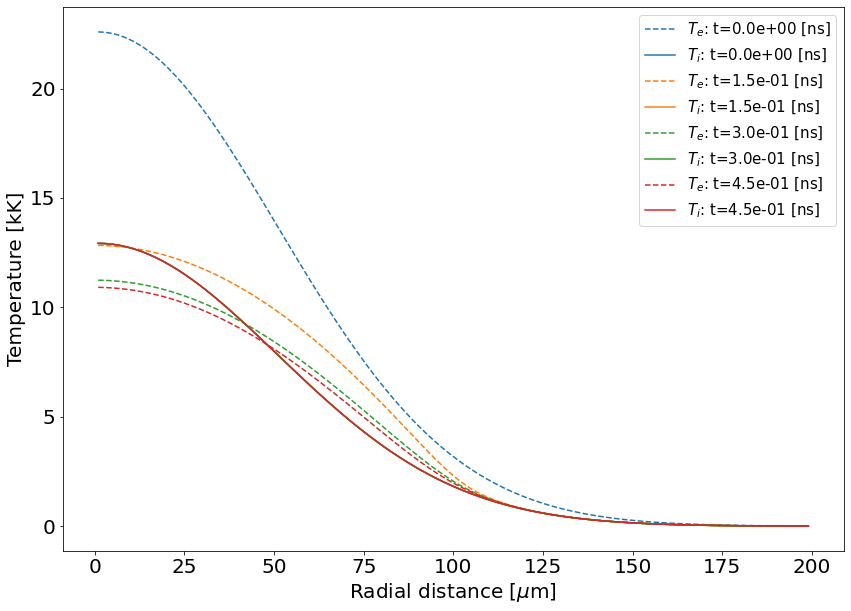

In [13]:
fig, ax = plt.subplots(figsize=(14,10),facecolor='w')

plot_times = (np.linspace(0,len(ttm.t_list)*0.1,num=4,endpoint=True)).astype(int)  # Intermediate times for plotting
# Plot temperature profiles at intermediate times
plot_idx = 0
for ti in plot_times:
    t = ttm.t_list[ti]
    ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
    ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
    plot_idx += 1

        
# Plot settings
ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
ax.set_ylabel("Temperature [kK]",fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_ylim(0,10.1)

ax.legend(fontsize=15)
plt.show()


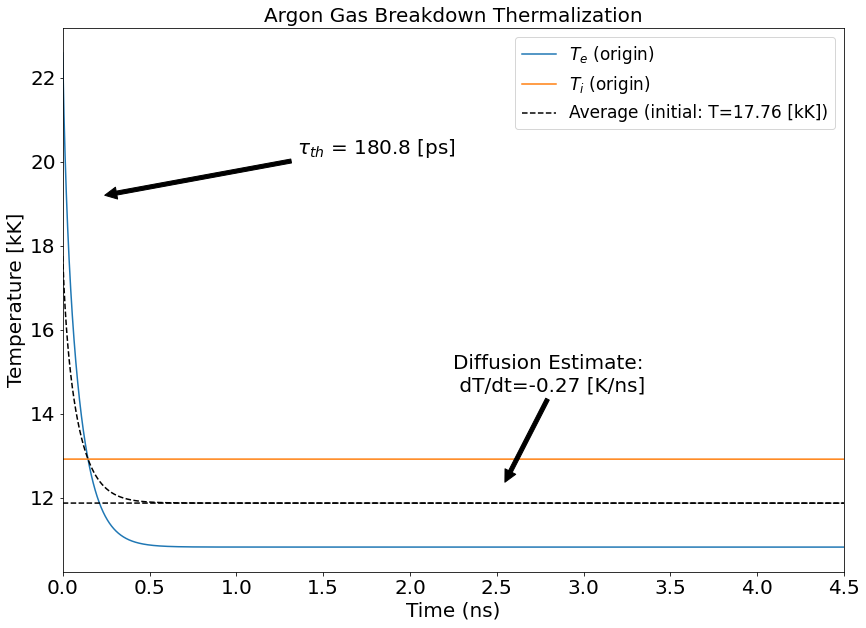

In [7]:
fig, ax = plt.subplots(figsize=(14,10),facecolor='w')

ti_1, ti_2 = -20000, -1
ti_1, ti_2 = -100, -1
T_av_1 = (ttm.Ti_list[ti_1][0] + ttm.Te_list[ti_1][0] )/2
T_av_2 = (ttm.Ti_list[ti_2][0] + ttm.Te_list[ti_2][0] )/2
dT_dt  = (T_av_2 - T_av_1)/(ttm.t_list[ti_2] - ttm.t_list[ti_1])
T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_list-ttm.t_list[ti_1]))

T_av = 0.5*(np.array(ttm.Te_list) + np.array(ttm.Ti_list))


ax.plot(np.array(ttm.t_list)*1e9, np.array(ttm.Te_list).T[0]*1e-3,label=r"$T_e$ (origin)")
ax.plot(np.array(ttm.t_list)*1e9, np.array(ttm.Ti_list).T[0]*1e-3,label=r"$T_i$ (origin)")
ax.plot(np.array(ttm.t_list)*1e9, T_eq_line*1e-3,'--k')#,label='Diffusion Estimate: dT/dt={0:.2f} [K/ns]'.format(dT_dt*1e-9))
ax.plot(np.array(ttm.t_list)*1e9, T_av[:,0]*1e-3,'--k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0,0]*1e-3))

ax.annotate(r'$\tau_{th}$' + ' = {0:.1f} [ps]'.format(ttm.experiment.τei_Equilibration*1e12), xy=(0.1, 0.6), xycoords='figure fraction',
            xytext=(0.3, .8), textcoords='axes fraction',
            va='top', ha='left',fontsize=20,
            arrowprops=dict(facecolor='black', shrink=0.02))

ax.annotate('Diffusion Estimate:\n dT/dt={0:.2f} [K/ns]'.format(dT_dt*1e-9), xy=(0.5, 0.2), xycoords='figure fraction',
            xytext=(0.5, .4), textcoords='axes fraction',
            va='top', ha='left',fontsize=20,
            arrowprops=dict(facecolor='black', shrink=0.02))


# Plot settings
ax.set_xlabel(r"Time (ns)", fontsize=20)
ax.set_ylabel("Temperature [kK]",fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0,ttm.tmax*1e9)

ax.set_title('Argon Gas Breakdown Thermalization',fontsize=20)
ax.legend(fontsize=17)
plt.show()

### Bulk Temperature Measurement

In [8]:
width_index = np.argmin(np.abs(grid.r - Argon.laser_width))

Te_bulks = np.array([  grid.integrate_f(Te[:-1]*ttm.n_e[:-1], endpoint=width_index)/grid.integrate_f(ttm.n_e[:-1], endpoint=width_index) for Te in ttm.Te_list])
Ti_bulks = np.array([  grid.integrate_f(Ti[:-1]*ttm.n_i[:-1], endpoint=width_index)/grid.integrate_f(ttm.n_i[:-1], endpoint=width_index) for Ti in ttm.Ti_list])
T_av = 0.5*(Te_bulks + Ti_bulks)


In [9]:
Te_bulks, Ti_bulks, T_av

(array([18000.        , 17998.1446955 , 17996.28913774, ...,
         9404.57951411,  9404.57951151,  9404.57950891]),
 array([10300.        , 10300.0000384 , 10300.0000768 , ...,
        10299.48670288, 10299.48669925, 10299.48669562]),
 array([14150.        , 14149.07236695, 14148.14460727, ...,
         9852.03310849,  9852.03310538,  9852.03310226]))

In [10]:
ttm.Te_list[0][width_index]

13699.214785139762

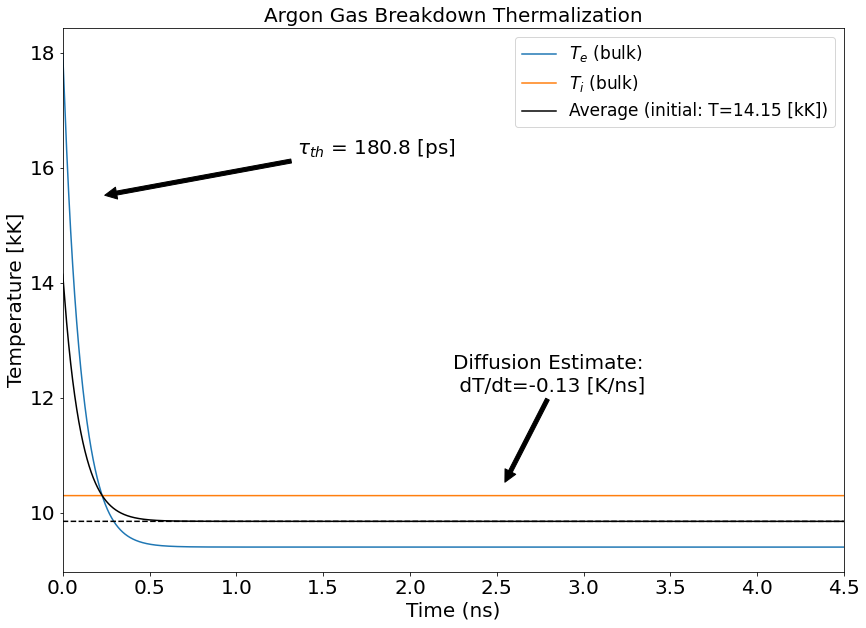

In [11]:
fig, ax = plt.subplots(figsize=(14,10),facecolor='w')


# ti_1, ti_2 = -20000, -1
ti_1, ti_2 = -100, -1

T_av_1 = T_av[ti_1]
T_av_2 = T_av[ti_2]

dT_dt  = (T_av_2 - T_av_1)/(ttm.t_list[ti_2] - ttm.t_list[ti_1])

T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_list-ttm.t_list[ti_1]))


ax.plot(np.array(ttm.t_list)*1e9, Te_bulks*1e-3,label=r"$T_e$ (bulk)")
ax.plot(np.array(ttm.t_list)*1e9, Ti_bulks*1e-3,label=r"$T_i$ (bulk)")
ax.plot(np.array(ttm.t_list)*1e9, T_eq_line*1e-3,'--k')#,label='Diffusion Estimate: dT/dt={0:.2f} [K/ns]'.format(dT_dt*1e-9))
ax.plot(np.array(ttm.t_list)*1e9, T_av*1e-3,'-k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0]*1e-3))

ax.annotate(r'$\tau_{th}$' + ' = {0:.1f} [ps]'.format(ttm.experiment.τei_Equilibration*1e12), xy=(0.1, 0.6), xycoords='figure fraction',
            xytext=(0.3, .8), textcoords='axes fraction',
            va='top', ha='left',fontsize=20,
            arrowprops=dict(facecolor='black', shrink=0.02))

ax.annotate('Diffusion Estimate:\n dT/dt={0:.2f} [K/ns]'.format(dT_dt*1e-9), xy=(0.5, 0.2), xycoords='figure fraction',
            xytext=(0.5, .4), textcoords='axes fraction',
            va='top', ha='left',fontsize=20,
            arrowprops=dict(facecolor='black', shrink=0.02))


# Plot settings
ax.set_xlabel(r"Time (ns)", fontsize=20)
ax.set_ylabel("Temperature [kK]",fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0,ttm.tmax*1e9)

ax.set_title('Argon Gas Breakdown Thermalization',fontsize=20)
ax.legend(fontsize=17)
plt.show()